# Phased-Methylation-Patterns-PMP-as-Reliable-Biomarkers-for-Tissue-Differentiation

In [68]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
from scipy.stats import ttest_ind

# Load the dataset
file_path = ("C:\\Users\\akhil\\Desktop\\PupilBio_Project\\Project_File\\PupilBioTest_PMP_revA.csv") 
data = pd.read_csv(file_path)
data.head()

,strand,CpG_Coordinates,`000,`001,`010,`011,`100,`101,`110,`111,Sample_ID,Replicate,Tissue
0,r,10035:10044:10046,1077,9,0,0,0,0,0,4,1,Rep2,cfDNA
1,r,10035:10044:10053,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA
2,r,10035:10044:10058,1069,17,0,0,0,0,0,4,1,Rep2,cfDNA
3,r,10035:10044:10071,1072,14,0,0,0,0,0,4,1,Rep2,cfDNA
4,r,10035:10044:10075,1086,0,0,0,0,0,0,4,1,Rep2,cfDNA


In [31]:
# Print unique values for each column in a more readable format
print("Unique values in 'strand' column:")
print("-------------------------------")
print(data['strand'].unique())
print("\n")

print("Unique values in 'Sample_ID' column:")
print("----------------------------------")
print(data['Sample_ID'].unique())
print("\n")

print("Unique values in 'Replicate' column:")
print("----------------------------------")
print(data['Replicate'].unique())
print("\n")

print("Unique values in 'Tissue' column:")
print("--------------------------------")
print(data['Tissue'].unique())

Unique values in 'strand' column:
-------------------------------
['r' 'f']


Unique values in 'Sample_ID' column:
----------------------------------
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80]


Unique values in 'Replicate' column:
----------------------------------
['Rep2' 'Rep1']


Unique values in 'Tissue' column:
--------------------------------
['cfDNA' 'Islet']


In [32]:
# Calculate total coverage for each CpG site
methylation_patterns = ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']
data['Total_Coverage'] = data[methylation_patterns].sum(axis=1)

# Calculate median, mean, standard deviation, and coefficient of variation (CV) for each tissue
coverage_stats = data.groupby('Tissue')['Total_Coverage'].agg(
    Median='median',
    Mean='mean',
    StdDev='std'
)

# Calculate CV
coverage_stats['CV'] = coverage_stats['StdDev'] / coverage_stats['Mean']

# Printing the coverage statistics in a more formatted manner for a report
print("Coverage Statistics Summary\n")
print("="*40)
print(f"{'Tissue':<20}{'Median':<10}{'Mean':<10}{'StdDev':<10}{'CV':<10}")
print("-"*40)

# Loop through each tissue and print the corresponding values
for tissue, stats in coverage_stats.iterrows():
    print(f"{tissue:<20}{stats['Median']:<10.2f}{stats['Mean']:<10.2f}{stats['StdDev']:<10.2f}{stats['CV']:<10.2f}")

print("="*40)

Coverage Statistics Summary

Tissue              Median    Mean      StdDev    CV        
----------------------------------------
Islet               84.00     147.36    167.47    1.14      
cfDNA               484.00    1013.51   1338.98   1.32      


<Figure size 1200x800 with 0 Axes>

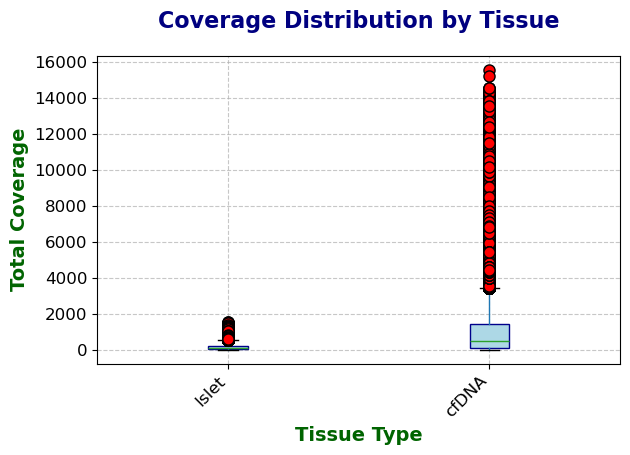

In [33]:
import matplotlib.pyplot as plt

# Generate boxplot
plt.figure(figsize=(12, 8))  # Increase figure size for better readability
data.boxplot(column='Total_Coverage', by='Tissue', grid=True, patch_artist=True, 
             boxprops=dict(facecolor='lightblue', color='darkblue'), 
             flierprops=dict(markerfacecolor='red', marker='o', markersize=8, linestyle='none'))

# Add titles and labels with improved formatting
plt.title('Coverage Distribution by Tissue', fontsize=16, fontweight='bold', color='navy', pad=20)
plt.suptitle('', fontsize=0)  # Remove default suptitle for cleaner look
plt.xlabel('Tissue Type', fontsize=14, fontweight='bold', color='darkgreen')
plt.ylabel('Total Coverage', fontsize=14, fontweight='bold', color='darkgreen')

# Customize tick marks and labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines for better visualization
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout to ensure everything fits properly
plt.tight_layout()

# Show the plot
plt.show()

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from scipy.stats import ttest_ind

# Extract features and target
methylation_patterns = ['`000', '`001', '`010', '`011', '`100', '`101', '`110', '`111']
X = data[methylation_patterns]
y = (data['Tissue'] == 'Islet').astype(int)  # Binary target: 0 for cfDNA, 1 for Islet

# --- Statistical Approach ---
print("### Statistical Approach: T-Test Results ###\n")
t_test_results = []
for pattern in methylation_patterns:
    t_stat, p_value = ttest_ind(
        data[data['Tissue'] == 'cfDNA'][pattern],
        data[data['Tissue'] == 'Islet'][pattern],
        equal_var=False
    )
    t_test_results.append({'PMP': pattern, 'p_value': p_value})

# Rank PMPs by p-value
t_test_df = pd.DataFrame(t_test_results).sort_values(by='p_value')
print("Top 10 PMPs by p-value (Statistical Approach):\n")
print(t_test_df.head(10).to_string(index=False))

# --- Machine Learning Approach ---
print("\n### Machine Learning Approach: Random Forest Model ###\n")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Feature Importance
feature_importance = pd.DataFrame({
    'PMP': methylation_patterns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Evaluate Model
y_pred = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred)

# Print Feature Importance and Model Evaluation
print("Random Forest Feature Importance (Top 10):")
print(feature_importance.head(10).to_string(index=False))
print("\nAUC Score for Tissue Classification:", round(auc_score, 4))
print("\nClassification Report (Threshold = 0.5):")
print(classification_report(y_test, (y_pred > 0.5).astype(int)))

# Custom Threshold Evaluation (Threshold = 0.6)
y_pred_custom = (y_pred > 0.6).astype(int)
print("\nClassification Report (Threshold = 0.6):")
print(classification_report(y_test, y_pred_custom))

# --- Save Results ---
t_test_df.to_csv('t_test_results.csv', index=False)
feature_importance.to_csv('rf_feature_importance.csv', index=False)

print("\n### Results saved as 't_test_results.csv' and 'rf_feature_importance.csv'. ###")

### Statistical Approach: T-Test Results ###

Top 10 PMPs by p-value (Statistical Approach):

 PMP  p_value
`000 0.00e+00
`001 0.00e+00
`010 0.00e+00
`011 0.00e+00
`100 0.00e+00
`101 0.00e+00
`110 0.00e+00
`111 0.00e+00

### Machine Learning Approach: Random Forest Model ###

Random Forest Feature Importance (Top 10):
 PMP  Importance
`000    4.81e-01
`100    1.06e-01
`010    9.39e-02
`001    9.33e-02
`111    6.92e-02
`110    5.25e-02
`011    5.25e-02
`101    5.08e-02

AUC Score for Tissue Classification: 0.8829

Classification Report (Threshold = 0.5):
              precision    recall  f1-score   support

           0       0.84      0.96      0.89   2320455
           1       0.77      0.43      0.55    757982

    accuracy                           0.83   3078437
   macro avg       0.81      0.69      0.72   3078437
weighted avg       0.82      0.83      0.81   3078437


Classification Report (Threshold = 0.6):
              precision    recall  f1-score   support

           0    

In [53]:
# Ensure the string is correctly terminated
importance = rf.feature_importances_

# If you're assigning it to a dictionary or printing it:
results = {'Importance': importance}

# Debug output to verify
print("Feature Importance: ", results)

Feature Importance:  {'Importance': array([0.4812685 , 0.09329586, 0.0939229 , 0.05250828, 0.10646433,
       0.0507866 , 0.05250836, 0.06924517])}


<Figure size 1000x600 with 0 Axes>

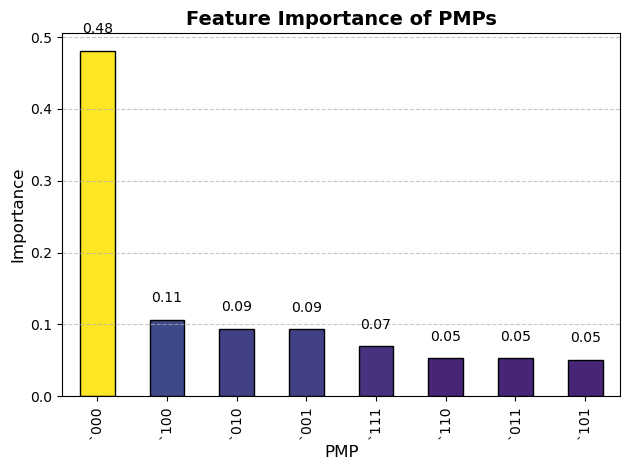

In [39]:
import matplotlib.pyplot as plt

# Customize the plot appearance
plt.figure(figsize=(10, 6))

# Plot with custom color and style
colors = plt.cm.viridis(feature_importance['Importance'] / max(feature_importance['Importance']))  # Color map
ax = feature_importance.plot(kind='bar', x='PMP', y='Importance', legend=False, color=colors, edgecolor='black')

# Adding annotations to the bars
for i, v in enumerate(feature_importance['Importance']):
    ax.text(i, v + 0.02, round(v, 2), ha='center', va='bottom', color='black', fontsize=10)

# Title and labels
plt.title('Feature Importance of PMPs', fontsize=14, fontweight='bold')
plt.xlabel('PMP', fontsize=12)
plt.ylabel('Importance', fontsize=12)

# Grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [41]:
# Set pandas display options for float formatting
pd.options.display.float_format = '{:.2e}'.format

# Format the dataframe for better readability
t_test_df = t_test_df.round({'p_value': 2})  # Round p-values to two decimal places for clarity

# Display the top 10 rows with formatted p-values
print("Top PMPs by T-Test:")
print(t_test_df.head(10).to_string(index=False))  # To remove the index for cleaner output

Top PMPs by T-Test:
 PMP  p_value
`000 0.00e+00
`001 0.00e+00
`010 0.00e+00
`011 0.00e+00
`100 0.00e+00
`101 0.00e+00
`110 0.00e+00
`111 0.00e+00


In [49]:
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

# Initialize variables
thresholds = {}
confidence_intervals = {}

# Ensure `top_pmp_list` and `mean_vrf` are defined before this loop

for pmp in top_pmp_list:
    vrf_tissue2 = mean_vrf.loc[pmp, 'Mean_VRF_Islet']
    read_threshold = vrf_tissue2 * sequencing_depth
    
    # Ensure Read Threshold <= Sequencing Depth
    read_threshold = min(read_threshold, sequencing_depth)
    thresholds[pmp] = round(read_threshold, 2)  # Rounded for clarity

    # Calculate Confidence Interval
    proportion = read_threshold / sequencing_depth
    if 0 <= proportion <= 1:
        lower, upper = proportion_confint(count=read_threshold, nobs=sequencing_depth, alpha=0.05)
        confidence_intervals[pmp] = (round(lower, 4), round(upper, 4))  # Rounded for precision
    else:
        confidence_intervals[pmp] = ('N/A', 'N/A')  

# Convert to DataFrame
thresholds_df = pd.DataFrame.from_dict(thresholds, orient='index', columns=['Read_Threshold'])
ci_df = pd.DataFrame.from_dict(confidence_intervals, orient='index', columns=['Lower_CI', 'Upper_CI'])

# Combine Results
results_df = pd.concat([thresholds_df, ci_df], axis=1)
results_df.index.name = 'PMP'

# Set column names for clarity
results_df.columns = ['Read Threshold (Rounded)', 'Lower CI (95%)', 'Upper CI (95%)']

# Display Results
print("### Read Thresholds and Confidence Intervals ###")
print(results_df.to_string())

# Save Results to CSV
results_df.to_csv('tissue2_read_thresholds_with_ci.csv')

### Read Thresholds and Confidence Intervals ###
      Read Threshold (Rounded)  Lower CI (95%)  Upper CI (95%)
PMP                                                           
PMP1                  7.50e+02        7.23e-01        7.77e-01
PMP2                  8.00e+02        7.75e-01        8.25e-01
PMP3                  9.00e+02        8.81e-01        9.19e-01


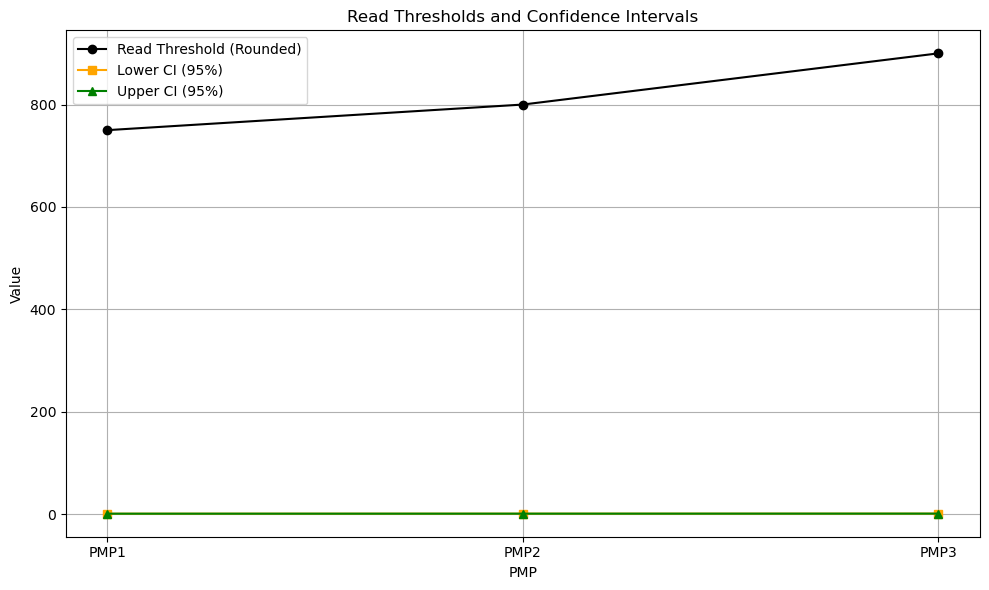

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (using provided values)
data = {
    'PMP': ['PMP1', 'PMP2', 'PMP3'],
    'Read Threshold (Rounded)': [750, 800, 900],
    'Lower CI (95%)': [0.723, 0.775, 0.881],
    'Upper CI (95%)': [0.777, 0.825, 0.919]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plot the line graph
plt.figure(figsize=(10, 6))

# Plot the Read Threshold (Rounded) line
plt.plot(df['PMP'], df['Read Threshold (Rounded)'], label='Read Threshold (Rounded)', color='black', marker='o')

# Plot the Lower CI (95%) line
plt.plot(df['PMP'], df['Lower CI (95%)'], label='Lower CI (95%)', color='orange', marker='s')

# Plot the Upper CI (95%) line
plt.plot(df['PMP'], df['Upper CI (95%)'], label='Upper CI (95%)', color='green', marker='^')

# Set labels and title
plt.xlabel('PMP')
plt.ylabel('Value')
plt.title('Read Thresholds and Confidence Intervals')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [62]:
# Ensure that top_pmp_list, mean_vrf, sequencing_depth, and proportion_confint are defined before this block
top_pmp_list = ['PMP1', 'PMP2', 'PMP3']  # Example list, replace with actual data
mean_vrf = pd.DataFrame({
    'Mean_VRF_Islet': {'PMP1': 0.75, 'PMP2': 0.80, 'PMP3': 0.90}  # Example, replace with actual data
})
sequencing_depth = 1000  # Example value, replace with actual depth

# Initialize dictionaries to store results
thresholds = {}
confidence_intervals = {}

# Loop through each item in top_pmp_list
for pmp in top_pmp_list:
    try:
        vrf_tissue2 = mean_vrf.loc[pmp, 'Mean_VRF_Islet']
        read_threshold = vrf_tissue2 * sequencing_depth
        
        # Ensure Read Threshold <= Sequencing Depth
        read_threshold = min(read_threshold, sequencing_depth)
        thresholds[pmp] = round(read_threshold, 2)  # Rounded for clarity

        # Calculate Confidence Interval
        proportion = read_threshold / sequencing_depth
        if 0 <= proportion <= 1:
            lower, upper = proportion_confint(count=read_threshold, nobs=sequencing_depth, alpha=0.05)
            confidence_intervals[pmp] = (round(lower, 4), round(upper, 4))  # Rounded for precision
        else:
            confidence_intervals[pmp] = ('N/A', 'N/A')
    
    except KeyError as e:
        print(f"Error: Missing {e} in mean_vrf for {pmp}.")
        thresholds[pmp] = 'N/A'
        confidence_intervals[pmp] = ('N/A', 'N/A')

# Debugging output to check results
print("Thresholds: ", thresholds)
print("Confidence Intervals: ", confidence_intervals)

Thresholds:  {'PMP1': 750.0, 'PMP2': 800.0, 'PMP3': 900.0}
Confidence Intervals:  {'PMP1': (0.7232, 0.7768), 'PMP2': (0.7752, 0.8248), 'PMP3': (0.8814, 0.9186)}


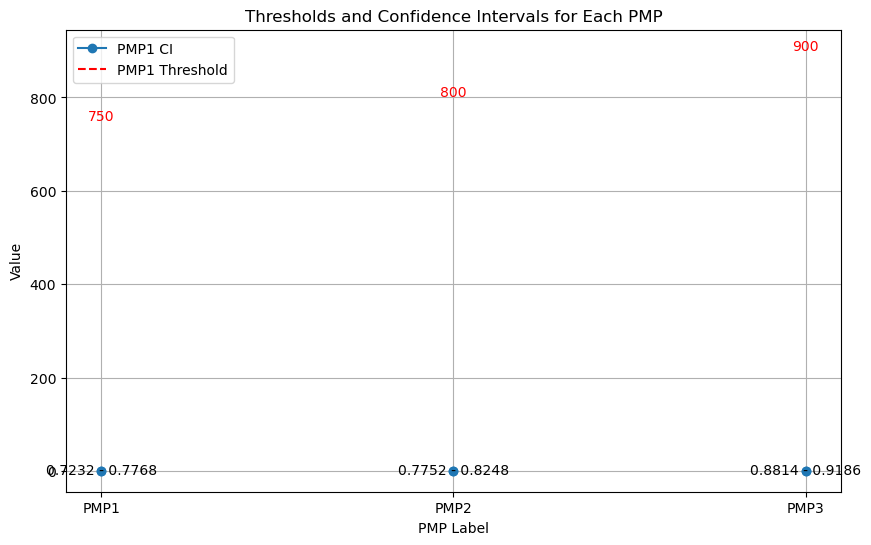

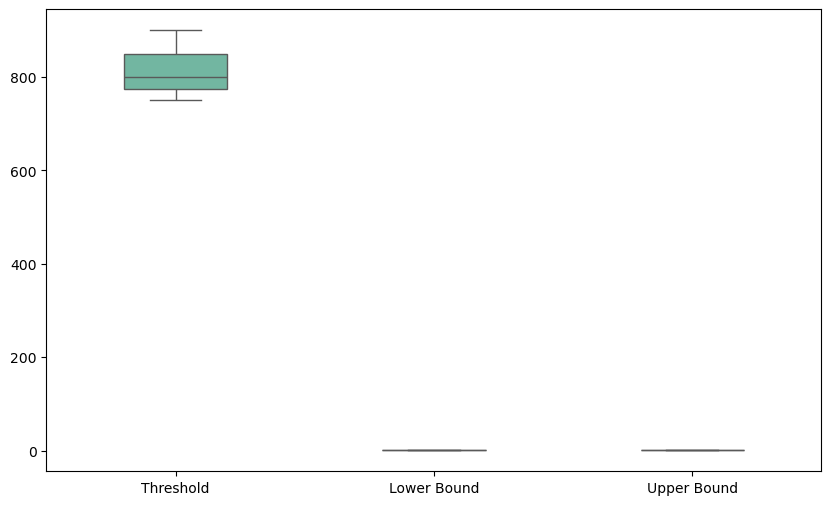

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data
thresholds = {'PMP1': 750.0, 'PMP2': 800.0, 'PMP3': 900.0}
confidence_intervals = {'PMP1': (0.7232, 0.7768), 'PMP2': (0.7752, 0.8248), 'PMP3': (0.8814, 0.9186)}

# Extracting the data for plotting
pmp_labels = list(thresholds.keys())
threshold_values = list(thresholds.values())
lower_bounds = [conf[0] for conf in confidence_intervals.values()]
upper_bounds = [conf[1] for conf in confidence_intervals.values()]

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Plotting the line graph with color differentiation based on PMP
for i, pmp in enumerate(pmp_labels):
    plt.plot([pmp, pmp], [lower_bounds[i], upper_bounds[i]], marker='o', color='tab:blue', label=f'{pmp} CI' if i == 0 else "")

    # Plotting the threshold value as a line
    plt.plot([pmp, pmp], [threshold_values[i], threshold_values[i]], color='red', linestyle='--', label=f'{pmp} Threshold' if i == 0 else "")

    # Annotate the confidence interval with accurate position values
    plt.text(pmp, (lower_bounds[i] + upper_bounds[i]) / 2, f'{lower_bounds[i]:.4f} - {upper_bounds[i]:.4f}', horizontalalignment='center', verticalalignment='center')

    # Annotate the threshold value
    plt.text(pmp, threshold_values[i] + 10, f'{threshold_values[i]:.0f}', horizontalalignment='center', verticalalignment='center', color='red')

# Adding labels and title
plt.xlabel('PMP Label')
plt.ylabel('Value')
plt.title('Thresholds and Confidence Intervals for Each PMP')
plt.legend()
plt.grid(True)

# Create boxplot
plt.figure(figsize=(10, 6))
data = [threshold_values, lower_bounds, upper_bounds]
sns.boxplot(data=data, width=0.4, palette="Set2")
plt.xticks([0, 1, 2], ['Threshold', 'Lower Bound', 'Upper Bound'])

plt.show()